In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

In [2]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        text = re.sub(r'[^\w\s]', '', text.lower().strip())
        return text.split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized = self.tokenizer(text)
        return [self.stoi.get(word, self.stoi["<UNK>"]) for word in tokenized]

In [3]:
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, img_folder, vocab, transform):
        self.data_pairs = data_pairs
        self.img_folder = img_folder
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_name, caption = self.data_pairs[idx]
        image = Image.open(os.path.join(self.img_folder, img_name)).convert("RGB")
        image = self.transform(image)
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        return image, torch.tensor(numericalized_caption), img_name

In [4]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        captions = [item[1] for item in batch]
        img_names = [item[2] for item in batch]
        images = torch.cat(images, dim=0)
        captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions, img_names

In [5]:
def build_vocab_and_loaders(image_folder, captions_txt, transform, batch_size, freq_threshold=5, test_size=0.1):
    with open(captions_txt, 'r') as f:
        lines = f.readlines()
    image_caption_pairs = []
    for line in lines:
        if ',' in line:
            parts = line.strip().split(',')
            img = parts[0]
            caption = ','.join(parts[1:])
            if os.path.isfile(os.path.join(image_folder, img)):
                image_caption_pairs.append((img, caption))

    captions = [caption for _, caption in image_caption_pairs]

    vocab = Vocabulary(freq_threshold)
    vocab.build_vocabulary(captions)

    train_pairs, val_pairs = train_test_split(image_caption_pairs, test_size=test_size, random_state=42)

    train_dataset = CaptionDataset(train_pairs, image_folder, vocab, transform)
    val_dataset = CaptionDataset(val_pairs, image_folder, vocab, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=MyCollate(pad_idx=vocab.stoi["<PAD>"]))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=MyCollate(pad_idx=vocab.stoi["<PAD>"]))

    return vocab, train_loader, val_loader

In [6]:
def visualize_samples(loader, vocab, num_samples=5):
    images, captions, img_names = next(iter(loader))
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        caption_tokens = [vocab.itos[idx.item()] for idx in captions[i] if idx.item() not in [vocab.stoi['<PAD>'], vocab.stoi['<SOS>'], vocab.stoi['<EOS>']]]
        plt.imshow(img)
        plt.title("Caption: " + ' '.join(caption_tokens))
        plt.axis('off')
        plt.show()

In [7]:
# class EncoderCNN(torch.nn.Module):
#     def __init__(self, embed_size):
#         super(EncoderCNN, self).__init__()
#         resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
#         for param in resnet.parameters():
#             param.requires_grad = False
#         self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
#         self.linear = torch.nn.Linear(resnet.fc.in_features, embed_size)
#         self.bn = torch.nn.BatchNorm1d(embed_size)

#     def forward(self, images):
#         features = self.resnet(images)
#         features = features.view(features.size(0), -1)
#         return self.bn(self.linear(features))
class EncoderCNN(torch.nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # remove avgpool and fc
        self.resnet = torch.nn.Sequential(*modules)
        self.adaptive_pool = torch.nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()

    def forward(self, images):
        features = self.resnet(images)  # (B, 2048, H, W)
        features = self.adaptive_pool(features)  # (B, 2048, 14, 14)
        features = features.view(features.size(0), 2048, -1).permute(0, 2, 1)  # (B, 196, 2048)
        return features

    def fine_tune(self, fine_tune=True):
        for param in self.resnet.parameters():
            param.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for param in c.parameters():
                param.requires_grad = fine_tune

In [8]:
class Attention(torch.nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = torch.nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = torch.nn.Linear(decoder_dim, attention_dim)
        self.full_att = torch.nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)               # (B, 196, att_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (B, 1, att_dim)
        att = torch.tanh(att1 + att2)
        alpha = torch.softmax(self.full_att(att), dim=1)   # (B, 196, 1)
        context = (encoder_out * alpha).sum(dim=1)         # (B, encoder_dim)
        return context, alpha

In [9]:
# class DecoderRNN(torch.nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
#         super(DecoderRNN, self).__init__()
#         self.embedding = torch.nn.Embedding(vocab_size, embed_size)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#         self.linear = torch.nn.Linear(hidden_size * 2, vocab_size)

#     def forward(self, features, captions):
#         embeddings = self.embedding(captions[:, :-1])
#         embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
#         hiddens, _ = self.lstm(embeddings)
#         outputs = self.linear(hiddens)
#         return outputs
class DecoderRNN(torch.nn.Module):
    def __init__(self, embed_size, decoder_dim, vocab_size, encoder_dim=2048, attention_dim=256):
        super().__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.dropout = torch.nn.Dropout(0.5)
        self.decode_step = torch.nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.init_h = torch.nn.Linear(encoder_dim, decoder_dim)
        self.init_c = torch.nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = torch.nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = torch.nn.Sigmoid()
        self.fc = torch.nn.Linear(decoder_dim, vocab_size)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        vocab_size = self.fc.out_features
        caption_len = captions.size(1)

        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(encoder_out)

        preds = torch.zeros(batch_size, caption_len, vocab_size).to(encoder_out.device)

        for t in range(caption_len):
            context, _ = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))
            context = gate * context

            input_lstm = torch.cat([embeddings[:, t], context], dim=1)
            h, c = self.decode_step(input_lstm, (h, c))

            preds[:, t] = self.fc(self.dropout(h))

        return preds

    def init_hidden_state(self, encoder_out):
        mean_encoder = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder)
        c = self.init_c(mean_encoder)
        return h, c


In [10]:
# class ImageCaptioningModel(torch.nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
#         super(ImageCaptioningModel, self).__init__()
#         self.encoder = EncoderCNN(embed_size)
#         self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

#     def forward(self, images, captions):
#         features = self.encoder(images)
#         outputs = self.decoder(features, captions)
#         return outputs
class ImageCaptioningModel(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        encoder_out = self.encoder(images)
        outputs = self.decoder(encoder_out, captions)
        return outputs

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, vocab, num_epochs=5, save_path="checkpoint.pth"):
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, captions, _ in loop:
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions)
            loss = criterion(outputs[:, :-1, :].reshape(-1, len(vocab)), captions[:, 1:].reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions, _ in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions)
                loss = criterion(outputs[:, :-1, :].reshape(-1, len(vocab)), captions[:, 1:].reshape(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    return best_val_loss, train_losses, val_losses

In [12]:
def plot_losses(train_losses, val_losses):
    epochs = list(range(1, len(train_losses) + 1))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# def generate_caption(model, image, vocab, device, max_length=20):
#     model.eval()
#     with torch.no_grad():
#         feature = model.encoder(image.unsqueeze(0).to(device))
#         inputs = feature
#         caption = [vocab.stoi["<SOS>"]]
#         for _ in range(max_length):
#             cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)
#             output = model.decoder(inputs, cap_tensor)
#             predicted = output.argmax(2)[:, -1].item()
#             caption.append(predicted)
#             if predicted == vocab.stoi["<EOS>"]:
#                 break
#     return ' '.join([vocab.itos[idx] for idx in caption[1:-1]])
def generate_caption_beam_search(model, image, vocab, device, beam_width=3, max_length=20):
    model.eval()
    with torch.no_grad():
        feature = model.encoder(image.unsqueeze(0).to(device))
        sequences = [[list([vocab.stoi["<SOS>"]]), 0.0]]

        for _ in range(max_length):
            all_candidates = []
            for seq, score in sequences:
                if seq[-1] == vocab.stoi["<EOS>"]:
                    all_candidates.append((seq, score))
                    continue
                cap_tensor = torch.tensor(seq).unsqueeze(0).to(device)
                output = model.decoder(feature, cap_tensor)
                probs = torch.nn.functional.log_softmax(output[0, -1], dim=0)
                topk = torch.topk(probs, beam_width)

                for idx in range(beam_width):
                    word_idx = topk.indices[idx].item()
                    word_score = topk.values[idx].item()
                    new_seq = seq + [word_idx]
                    new_score = score + word_score
                    all_candidates.append((new_seq, new_score))

            # Keep best sequences
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_width]

        best_seq = sequences[0][0]
        caption_words = [vocab.itos[idx] for idx in best_seq if idx not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]
        return ' '.join(caption_words)

In [14]:
def generate_submission(model, val_loader, vocab, device, output_csv="submission.csv"):
    model.eval()
    results = []
    with torch.no_grad():
        for images, _, img_names in val_loader:
            for i in range(len(images)):
                # caption = generate_caption(model, images[i], vocab, device)
                caption = generate_caption_beam_search(model, images[i], vocab, device, beam_width=3)
                results.append({"image": img_names[i], "caption": caption})
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Submission saved to {output_csv}")

In [15]:
image_folder = "/kaggle/input/images-captions/Images"
captions_txt = "/kaggle/input/images-captions/captions.txt"
batch_size = 64
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [16]:
vocab, train_loader, val_loader = build_vocab_and_loaders(
    image_folder,
    captions_txt,
    transform,
    batch_size=batch_size,
    freq_threshold=3
)

In [17]:
num_images = len([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print(f"Total images: {num_images}")

Total images: 8091


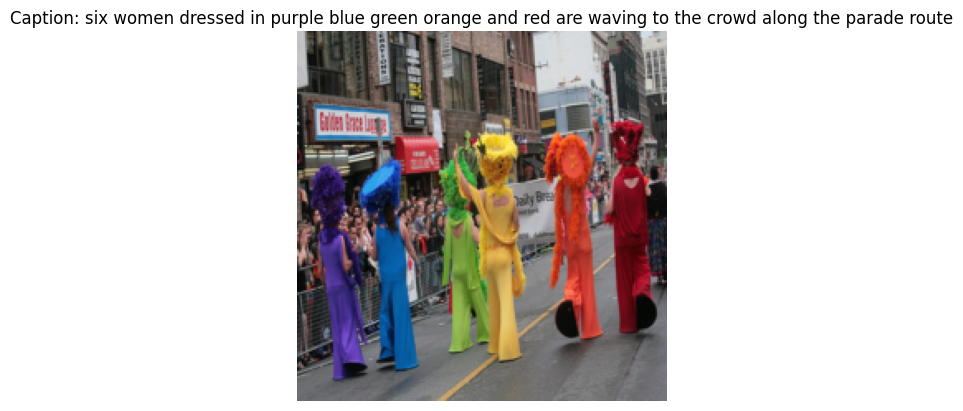

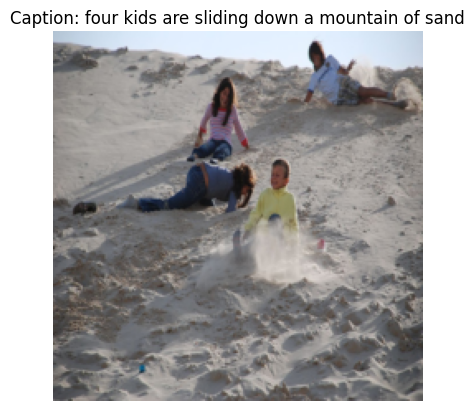

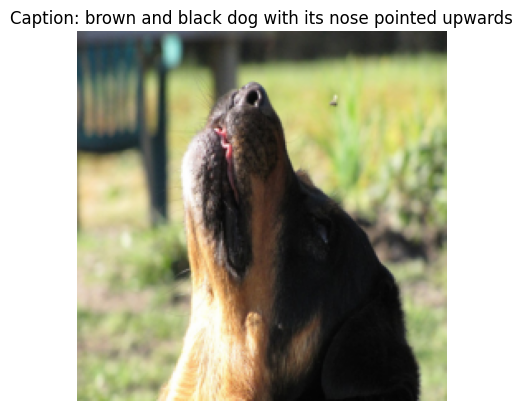

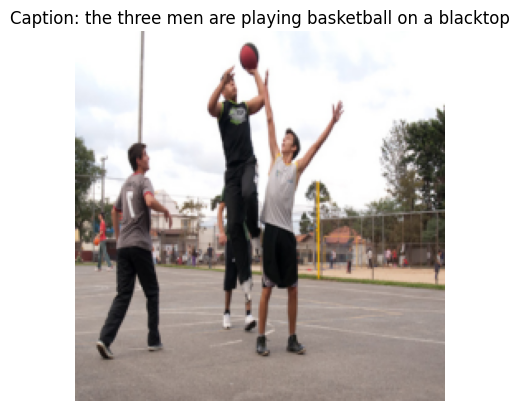

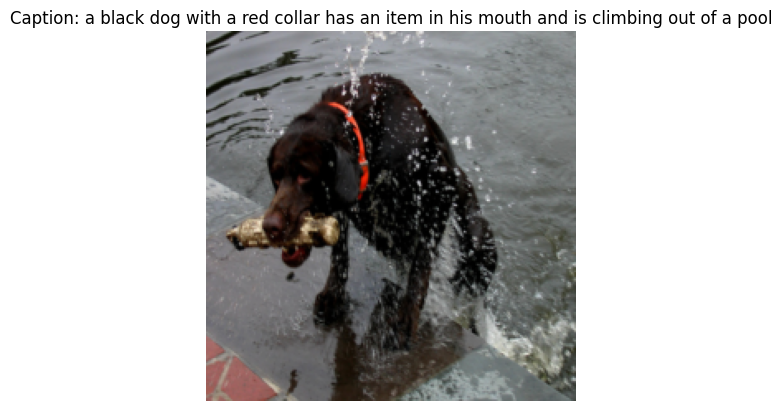

In [18]:
visualize_samples(train_loader, vocab, num_samples=5)

In [19]:
# model = ImageCaptioningModel(
#     embed_size=256,
#     hidden_size=512,
#     vocab_size=len(vocab),
#     num_layers=2
# ).to(device)
encoder = EncoderCNN(encoded_image_size=14)  # uses pretrained ResNet
decoder = DecoderRNN(
    embed_size=256,          # same as embedding size
    decoder_dim=512,         # hidden size of your LSTM
    vocab_size=len(vocab),   # total vocabulary size
    encoder_dim=2048,        # default for ResNet
    attention_dim=256        # size of attention layer
)

model = ImageCaptioningModel(encoder, decoder).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [20]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer=torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

best_val_loss, train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    device, vocab,
    num_epochs=num_epochs,
    save_path="caption_model.pth"
)

Epoch 1/20: 100%|██████████| 569/569 [14:52<00:00,  1.57s/it, loss=4.76]


Epoch 1 Training Loss: 5.1992
Epoch 1 Validation Loss: 4.5404
Model saved to caption_model.pth


Epoch 2/20: 100%|██████████| 569/569 [14:20<00:00,  1.51s/it, loss=4.02]


Epoch 2 Training Loss: 4.3865
Epoch 2 Validation Loss: 4.1224
Model saved to caption_model.pth


Epoch 3/20: 100%|██████████| 569/569 [14:23<00:00,  1.52s/it, loss=3.96]


Epoch 3 Training Loss: 4.0373
Epoch 3 Validation Loss: 3.8637
Model saved to caption_model.pth


Epoch 4/20: 100%|██████████| 569/569 [14:22<00:00,  1.52s/it, loss=3.85]


Epoch 4 Training Loss: 3.8027
Epoch 4 Validation Loss: 3.6746
Model saved to caption_model.pth


Epoch 5/20: 100%|██████████| 569/569 [14:27<00:00,  1.52s/it, loss=3.58]


Epoch 5 Training Loss: 3.6247
Epoch 5 Validation Loss: 3.5295
Model saved to caption_model.pth


Epoch 6/20: 100%|██████████| 569/569 [14:30<00:00,  1.53s/it, loss=3.24]


Epoch 6 Training Loss: 3.4798
Epoch 6 Validation Loss: 3.4170
Model saved to caption_model.pth


Epoch 7/20: 100%|██████████| 569/569 [14:26<00:00,  1.52s/it, loss=3.14]


Epoch 7 Training Loss: 3.3548
Epoch 7 Validation Loss: 3.3190
Model saved to caption_model.pth


Epoch 8/20: 100%|██████████| 569/569 [14:30<00:00,  1.53s/it, loss=3.3]


Epoch 8 Training Loss: 3.2486
Epoch 8 Validation Loss: 3.2469
Model saved to caption_model.pth


Epoch 9/20: 100%|██████████| 569/569 [14:31<00:00,  1.53s/it, loss=3.18]


Epoch 9 Training Loss: 3.1534
Epoch 9 Validation Loss: 3.1772
Model saved to caption_model.pth


Epoch 10/20: 100%|██████████| 569/569 [14:27<00:00,  1.53s/it, loss=3.2]


Epoch 10 Training Loss: 3.0712
Epoch 10 Validation Loss: 3.1189
Model saved to caption_model.pth


Epoch 11/20: 100%|██████████| 569/569 [14:28<00:00,  1.53s/it, loss=3.13]


Epoch 11 Training Loss: 2.9969
Epoch 11 Validation Loss: 3.0748
Model saved to caption_model.pth


Epoch 12/20: 100%|██████████| 569/569 [14:26<00:00,  1.52s/it, loss=3.1]


Epoch 12 Training Loss: 2.9251
Epoch 12 Validation Loss: 3.0299
Model saved to caption_model.pth


Epoch 13/20: 100%|██████████| 569/569 [14:25<00:00,  1.52s/it, loss=2.63]


Epoch 13 Training Loss: 2.8636
Epoch 13 Validation Loss: 2.9874
Model saved to caption_model.pth


Epoch 14/20: 100%|██████████| 569/569 [14:27<00:00,  1.52s/it, loss=3.1]


Epoch 14 Training Loss: 2.8025
Epoch 14 Validation Loss: 2.9594
Model saved to caption_model.pth


Epoch 15/20: 100%|██████████| 569/569 [14:28<00:00,  1.53s/it, loss=2.62]


Epoch 15 Training Loss: 2.7464
Epoch 15 Validation Loss: 2.9236
Model saved to caption_model.pth


Epoch 16/20: 100%|██████████| 569/569 [14:30<00:00,  1.53s/it, loss=2.8]


Epoch 16 Training Loss: 2.6946
Epoch 16 Validation Loss: 2.9053
Model saved to caption_model.pth


Epoch 17/20: 100%|██████████| 569/569 [14:27<00:00,  1.53s/it, loss=2.6]


Epoch 17 Training Loss: 2.6450
Epoch 17 Validation Loss: 2.8743
Model saved to caption_model.pth


Epoch 18/20: 100%|██████████| 569/569 [14:23<00:00,  1.52s/it, loss=2.57]


Epoch 18 Training Loss: 2.5980
Epoch 18 Validation Loss: 2.8479
Model saved to caption_model.pth


Epoch 19/20: 100%|██████████| 569/569 [14:25<00:00,  1.52s/it, loss=3.02]


Epoch 19 Training Loss: 2.5544
Epoch 19 Validation Loss: 2.8409
Model saved to caption_model.pth


Epoch 20/20: 100%|██████████| 569/569 [14:23<00:00,  1.52s/it, loss=2.61]


Epoch 20 Training Loss: 2.5105
Epoch 20 Validation Loss: 2.8132
Model saved to caption_model.pth


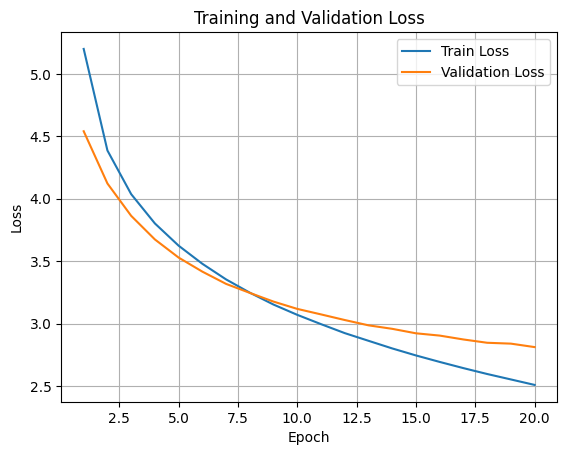

In [21]:
plot_losses(train_losses, val_losses)

In [22]:
# Uncomment to generate CSV after training
generate_submission(model, val_loader, vocab, device, output_csv="submission.csv")

Submission saved to submission.csv
